In [1]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
from pydmd import DMD
from skimage.util import random_noise

In [13]:
def my_dmd(X, Y, truncate=None):   
    U2,Sig2,Vh2 = np.linalg.svd(X, False) # SVD of input matrix  
    if truncate is None:
#         r = len(Sig2)
        r = 3
    else:
        truncate
    U = U2[:,:r]
    Sig = np.diag(Sig2)[:r,:r]
    V = Vh2.conj().T[:,:r]
    Atil = np.dot(np.dot(np.dot(U.conj().T, Y), V), np.linalg.inv(Sig)) # build A tilde
    mu,W = np.linalg.eig(Atil)
    Phi = np.dot(np.dot(np.dot(Y, V), np.linalg.inv(Sig)), W) # build DMD modes
    return mu, Phi

In [14]:
def saliency_detect(img):
    
    # Converting RGB Colorspace to YUV Colorspace
    img_YUV = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    Y1,U,V = cv2.split(img_YUV)

    # Converting RGB Colorspace to LAB Colorspace
    img_LAB = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    L,a,b = cv2.split(img_LAB)

    # Converting RGB Colorspace to LAB Colorspace
    img_YCrCb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    Y2, Cr, Cb = cv2.split(img_YCrCb)

    # ------ Computing Color based saliency map -------

    # Vectoring the color space channels
    a_vec = a.reshape([a.shape[0]*a.shape[1],1])
    b_vec = b.reshape([b.shape[0]*b.shape[1],1])
    U_vec = U.reshape([U.shape[0]*U.shape[1],1])
    V_vec = V.reshape([V.shape[0]*V.shape[1],1])
    Cr_vec = Cr.reshape([Cr.shape[0]*Cr.shape[1],1])
    Cb_vec = Cb.reshape([Cb.shape[0]*Cb.shape[1],1])
    D1_vec = b_vec + V_vec + Cr_vec
    D2_vec = a_vec + U_vec + Cb_vec

    # Static image representation for DMD
    X1 = np.concatenate ((b_vec,V_vec,Cr_vec,D1_vec,V_vec,Cr_vec,b_vec,D1_vec,D1_vec,Cr_vec,V_vec,b_vec,V_vec,Cr_vec,D1_vec,b_vec,V_vec,b_vec,D1_vec,Cr_vec),axis=1)
    X2 = np.concatenate((a_vec,U_vec,Cb_vec,D2_vec,U_vec,Cb_vec,a_vec,D2_vec,D2_vec,Cb_vec,U_vec,a_vec,U_vec,Cb_vec,D2_vec,a_vec,U_vec,a_vec,D2_vec,Cb_vec),axis=1)
    
    S1 = X1[:,0:X1.shape[1]-1]
    S2 = X1[:,1:X1.shape[1]]
    S3 = X2[:,0:X2.shape[1]-1]
    S4 = X2[:,1:X2.shape[1]]
    
    # Performing DMD on the above matrices
    [eig_val1, Phi1] = my_dmd(S1, S2, truncate=None)
    [eig_val1, Phi2] = my_dmd(S3, S4, truncate=None)
    

    # Seperating the low rank and sparse components
    # Intermediate singular values represent salient part of an image while smaller and larger values represent non-salient parts
    X_lowRank1 = np.concatenate((Phi1[:,0].reshape([Phi1.shape[0],1]),Phi1[:,5:len(X1)]),axis=1)
    X_sparse1 = Phi1[:,2:5]
    X_lowRank2 = np.concatenate((Phi2[:,0].reshape([Phi2.shape[0],1]),Phi2[:,5:len(X2)]),axis=1)
    X_sparse2 = Phi2[:,2:5]

    # Normalizing the low rank and sparse matrices
    X_lowRank_norm1 = (X_lowRank1 - np.min(X_lowRank1)) / (np.max(X_lowRank1)-np.min(X_lowRank1))
    X_sparse_norm1 = (X_sparse1 - np.min(X_sparse1)) / (np.max(X_sparse1)-np.min(X_sparse1))
    X_lowRank_norm2 = (X_lowRank2 - np.min(X_lowRank2)) / (np.max(X_lowRank2)-np.min(X_lowRank2))
    X_sparse_norm2 = (X_sparse2 - np.min(X_sparse2)) / (np.max(X_sparse2)-np.min(X_sparse2))

    # Generating the final sparse and low rank components
    X_sparse_out = X_sparse_norm1 + X_sparse_norm2
    X_lowRank_out = X_lowRank_norm1 + X_lowRank_norm2

    # Generating Saliency Map
    w = 0.1 # Weight
    SM_color_vec = np.real((X_sparse_out - w*X_lowRank_out)**2)

    # ------ Computing Luminance based saliency map -------

    # Computing Singular Value Decomposition to the 3 matrices (L, Y1, Y2) - Luminance Components
    u_L, s_L, vh_L = np.linalg.svd(L, full_matrices=True)
    u_Y1, s_Y1, vh_Y1 = np.linalg.svd(Y1, full_matrices=True)
    u_Y2, s_Y2, vh_Y2 = np.linalg.svd(Y2, full_matrices=True)

    # Reconstruction of luminance data matrices using n intermediate singular values

    n = 3 # Number of singular values taken

    # Range of the singular values taken
    r1 = int(u_L.shape[0]/2) # Starting range
    r2 = r1 + n # Ending range

    # Reconstructed data matrices
    L_rec= u_L[:,r1:r2]@np.diag(s_L[r1:r2])@vh_L[r1:r2,:] 
    Y1_rec = u_Y1[:,r1:r2]@np.diag(s_Y1[r1:r2])@vh_Y1[r1:r2,:] 
    Y2_rec = u_Y2[:,r1:r2]@np.diag(s_Y2[r1:r2])@vh_Y2[r1:r2,:] 

    # Vectorize the reconstructed data matrices
    L_rec_vec = L_rec.reshape([L_rec.shape[0]*L_rec.shape[1],1])
    Y1_rec_vec = Y1_rec.reshape([Y1_rec.shape[0]*Y1_rec.shape[1],1])
    Y2_rec_vec = Y2_rec.reshape([Y2_rec.shape[0]*Y2_rec.shape[1],1])

    # Generating data matrix that is to be fed into the DMD
    X = np.concatenate((L_rec_vec,Y1_rec_vec,Y2_rec_vec,L_rec_vec,Y2_rec_vec,Y1_rec_vec,Y1_rec_vec,L_rec_vec,Y2_rec_vec,Y2_rec_vec,L_rec_vec,Y1_rec_vec,Y2_rec_vec,Y1_rec_vec,L_rec_vec,Y1_rec_vec,Y2_rec_vec,L_rec_vec),axis=1)

    # Performing DMD for the permutated columns
    S5 = X[:,0:X.shape[1]-1]
    S6 = X[:,1:X.shape[1]]
    [eig_val, Phi] = my_dmd(S5, S6, truncate=None)

    # Seperating the low rank and sparse components
    # Intermediate singular values represent salient part of an image while smaller and larger values represent non-salient parts
    X_lowRank = np.concatenate((Phi[:,0].reshape([Phi.shape[0],1]),Phi[:,3:len(X)]),axis=1)
    X_sparse = Phi[:,2:len(X)]

    # Normalizing the sparse matrix and low rank matrix
    X_lowRank_norm = (X_lowRank - np.min(X_lowRank)) / (np.max(X_lowRank)-np.min(X_lowRank))
    X_sparse_norm = (X_sparse - np.min(X_sparse)) / (np.max(X_sparse)-np.min(X_sparse))

    # --------- Generating Saliency Map ----------------
    W = 0 # Weight - Always zero as luminance based saliency map takes only sparse component of DMD
    SM_luminous_vec = np.real((X_sparse_norm - W*X_lowRank_norm)**2)

    SM_final_vec = []
    for i in range(len(SM_luminous_vec)):
        SM_final_vec.append(max(SM_luminous_vec[i],SM_color_vec[i]))
    SM_final = np.array(SM_final_vec).reshape([img.shape[0],img.shape[1]])
    
    # Creating a binary mask
    threshhold = 0.5
    binary_mask = np.zeros((SM_final.shape[0],SM_final.shape[1]),dtype=int)
    for i in range(SM_final.shape[0]):
        for j in range(SM_final.shape[1]):
            if SM_final[i,j] > threshhold:
                binary_mask[i,j] = 1
            else:
                binary_mask[i,j] = 0
                
    return binary_mask


<h1><center>Statistical Measures</center></h1>

In [15]:
# Precision Recall Function
def PR_score(salient_img,gt_sample):
    total_salient_pixels = (salient_img == 1).sum()
    total_groundTruth_pixels = (gt_sample == 255).sum()
    TP = 0 # True Positive 
    for i in range(salient_img.shape[0]):
        for j in range(salient_img.shape[1]):
            if salient_img[i,j].any() == gt_sample[i,j].any():
                TP += 1
    precision = TP/total_salient_pixels
    recall = TP/total_groundTruth_pixels
    return precision, recall

In [16]:
# F-Measure function
def F_score(precision,recall):
    beta_2 = 0.3 # Set as 0.3 to give more weight to precision than recall
    F_measure = ((1 + beta_2) * precision * recall) / (beta_2 * (precision + recall))
    return F_measure

In [17]:
# Generation of Binary Mask
def binary_mask(img): 
    threshhold = 0.75
    binary_mask = np.zeros((img.shape[0],img.shape[1]),dtype=int)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if img[i,j].any() > threshhold:
                binary_mask[i,j] = 1
            else:
                binary_mask[i,j] = 0 
    return binary_mask

In [18]:
# Mean Absolute Error
def MAE(gt_bin,salient_img_bin):
    W = gt_bin.shape[1]
    H = gt_bin.shape[0]
    mae = np.sum(np.sqrt(np.abs((salient_img - gt_bin)**2)))/(W*H)
    return mae

In [19]:
# Confusion Matrix
                                                
def confusion_matrix(salient_image,gt_binary):
    
    FP = 0 # False Positve
    TP = 0 # True Positive
    TN = 0 # True Negative
    FN = 0 # False Negative
    
    for i in range(salient_img.shape[0]):
        for j in range(salient_img.shape[1]):
            if salient_img[i,j] == 1 and gt_binary[i,j] == 1:
                TP += 1
            elif salient_img[i,j] == 1 and gt_binary[i,j] == 0:
                FP += 1
            elif salient_img[i,j] == 0 and gt_binary[i,j] == 1:
                FN += 1   
            else:
                TN += 1
            
    confusion_matrix = np.array([[TP,FP],[FN,TN]])
    
    return confusion_matrix

In [20]:
# Receiver Operating Charecteristics - ROC Curve

def conf_mat_rates(conf_mat):
    TP = conf_mat[0,0]
    FP = conf_mat[0,1]
    FN = conf_mat[1,0]
    TN = conf_mat[1,1]
    TPR = TP / (TP + FN) # True Positive Rate
    FPR = FP / (FP +TN) # False Positive Rate
    FNR = FN / (FN + TP) # False Negative Rate
    TNR = TN / (TN + FP) # True Negative Rate
    return FPR, TPR, FNR, TNR

In [21]:
# # Summarizing all the Statistical Measures together

# def metrices(salient_img,gt_sample):
    
#     # Precision - recall
#     PR = PR_score(salient_img,gt_sample)
#     precision,recall = PR[0], PR[1]
    
#     # F-Measure
#     f_score = F_score()
    
#     # Mean Absolute Error
#     gt_bin = binary_mask(gt_sample)
#     mean_abs_err = MAE(gt_bin,salient_img)
    
#     # Confusion Matrix
#     conf_mat = confusion_matrix(salient_img, gt_bin)
    
#     rates = conf_mat_rates(conf_mat)
#     # ROC Values
#     FPR = rates[0] # False Positive Rate
#     TPR = rates[1] # True Positive Rate
#     roc_values = [FPR,TPR]
    
#     # Accuracy
#     FNR = rates[2]
#     TNR = rates[3]
#     accuracy = (TNR + TPR)/2
    
#     return precision,recall,f_score,mean_abs_err,conf_mat,roc_values,accuracy

# metrics = metrices(salient_img,gt_sample)
# precision,recall,F_score,mean_abs_err,conf_mat,roc_values,accuracy = metrics[0], metrics[1], metrics[2], metrics[3], metrics[4], metrics[5], metrics[6]
# print('''
# Precision:{0}\n
# Recall:{1}\n
# F-Score:{2}\n
# MAE:{3}\n
# Confusion Matrix:\n{4}
# \nROC:{5}\n
# Accuracy:{6}
# '''.format(precision,recall,F_score,mean_abs_err,conf_mat,roc_values,accuracy))

In [22]:
import os

im = "C:\\Users\\HP\\Semester V Codes\\End Semester Project\\MIS + SIP\\final_images"
g_t = "C:\\Users\\HP\\Semester V Codes\\End Semester Project\\MIS + SIP\\final_gt_mask"

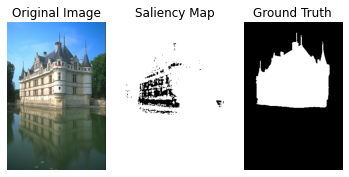

Confusion Matrix:
 [[21603 79742]
 [ 4897   558]]


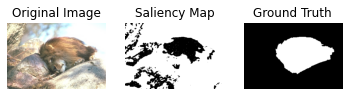

Confusion Matrix:
 [[12050 71480]
 [11153 12117]]


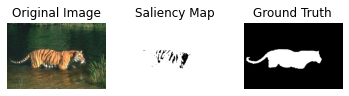

Confusion Matrix:
 [[12096 92660]
 [ 2033    11]]


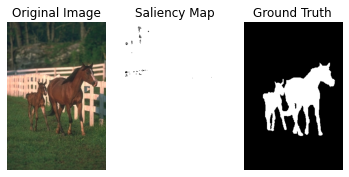

Confusion Matrix:
 [[16809 89760]
 [    2   229]]


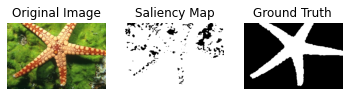

Confusion Matrix:
 [[24210 73427]
 [ 2688  6475]]


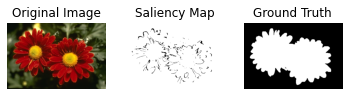

Confusion Matrix:
 [[43603 60100]
 [ 3091     6]]


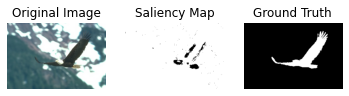

Confusion Matrix:
 [[ 6282 98174]
 [ 1896   448]]


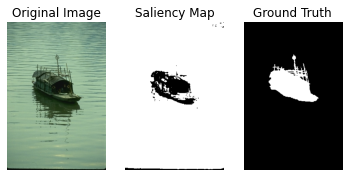

Confusion Matrix:
 [[ 3104 97072]
 [ 4901  1723]]


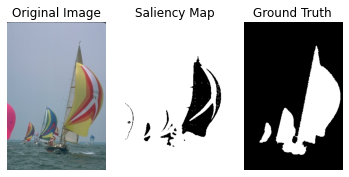

Confusion Matrix:
 [[10718 84066]
 [11791   225]]


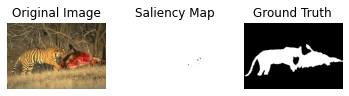

Confusion Matrix:
 [[20279 86469]
 [   52     0]]


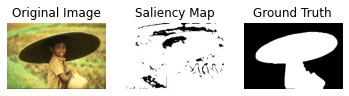

Confusion Matrix:
 [[41354 54927]
 [ 2406  8113]]


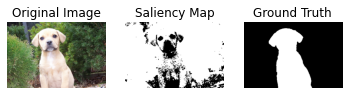

Confusion Matrix:
 [[15316 73079]
 [11238  6767]]


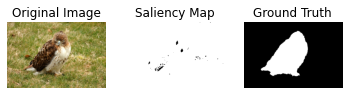

Confusion Matrix:
 [[18774 86971]
 [  555   100]]


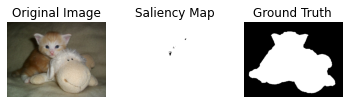

Confusion Matrix:
 [[50043 70635]
 [  122     0]]


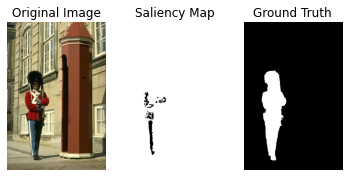

Confusion Matrix:
 [[ 7843 97513]
 [ 1444     0]]


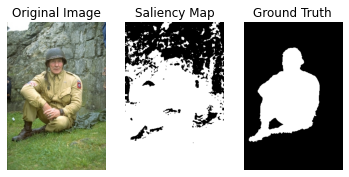

Confusion Matrix:
 [[23664 50921]
 [ 3007 29208]]


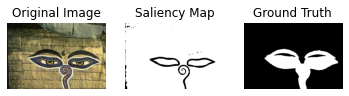

Confusion Matrix:
 [[14555 87114]
 [ 4513   618]]


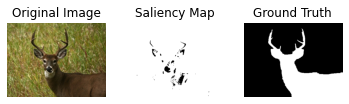

Confusion Matrix:
 [[29174 88418]
 [ 2394    14]]


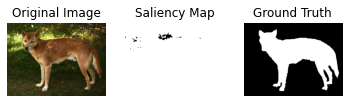

Confusion Matrix:
 [[36461 80984]
 [    4   951]]


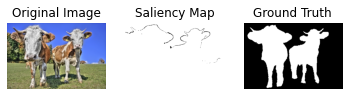

Confusion Matrix:
 [[38258 67700]
 [  155   687]]


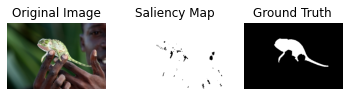

Confusion Matrix:
 [[ 6855 98701]
 [  296   948]]


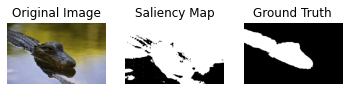

Confusion Matrix:
 [[16945 57490]
 [ 1962 22803]]


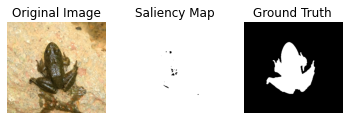

Confusion Matrix:
 [[ 22321 124115]
 [   352     12]]


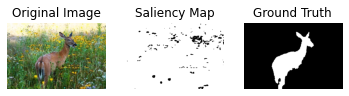

Confusion Matrix:
 [[13185 89927]
 [   65  3623]]


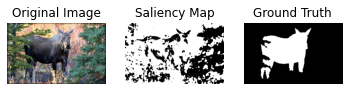

Confusion Matrix:
 [[14418 49981]
 [ 7677 26724]]


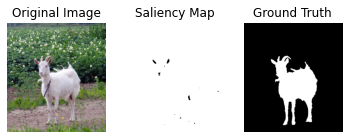

Confusion Matrix:
 [[ 20094 123917]
 [   352     37]]


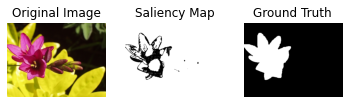

Confusion Matrix:
 [[ 10836 100131]
 [  8952     81]]


In [23]:
P = [] # Precision values
R = [] # Recall values
F = [] # F-measure values
Mean_Abs_Error = [] # Mean Absolute Error
ROC = [] # ROC values
ACC = [] # Accuracy values

for e,i in enumerate(os.listdir(im)):
    
    img = cv2.imread(os.path.join(im,i))  
    j=i[:-3]+"png"
    
    gt_sample = cv2.imread(os.path.join(g_t,j)) # Ground Truth Image
    image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Original Image
    salient_img = saliency_detect(image)  # Salient Image

    plt.subplot(1,3,1)
    plt.imshow(image) # RGB Image
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1,3,2)
    plt.imshow(salient_img,cmap="gray") # Salient Image
    plt.title('Saliency Map')
    plt.axis('off')

    plt.subplot(1,3,3)
    plt.imshow(gt_sample) # Ground Truth Image
    plt.title('Ground Truth')
    plt.axis('off')

    plt.show()
    
    # --------------- Statistical Analysis ---------------
    
    precision,recall = PR_score(salient_img,gt_sample)
    
    # F-Measure
    f_score = F_score(precision,recall)
    
    # Mean Absolute Error
    gt_bin = binary_mask(gt_sample)
    mean_abs_err = MAE(gt_bin,salient_img)
    
    # Confusion Matrix
    conf_mat = confusion_matrix(salient_img, gt_bin)
    print('Confusion Matrix:\n',conf_mat)
    
    rates = conf_mat_rates(conf_mat)
    # ROC Values
    FPR = rates[0] # False Positive Rate
    TPR = rates[1] # True Positive Rate
    roc_values = [FPR,TPR]
    
    # Accuracy
    FNR = rates[2]
    TNR = rates[3]
    accuracy = (TNR + TPR)/2
    
    P.append(precision)
    R.append(recall)
    F.append(f_score) 
    Mean_Abs_Error.append(mean_abs_err)
    ROC.append(roc_values)
    ACC.append(accuracy)
    

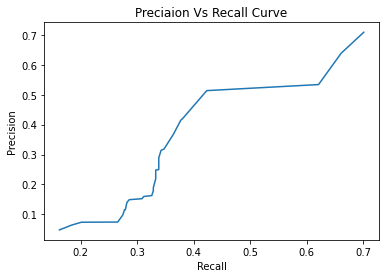

In [24]:
# Precision Vs Recall Curve
plt.plot(sorted(R),sorted(P)) # R - Recall ; P - Precision
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Preciaion Vs Recall Curve')
plt.show()

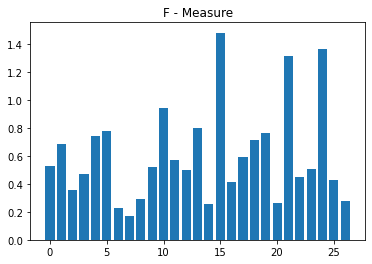

In [25]:
# F - Measure
plt.bar(np.arange(len(F)),F) # F - Measure
plt.title('F - Measure')
plt.show()

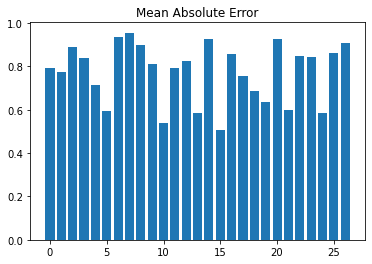

In [26]:
# Mean Absolute Error
plt.bar(np.arange(len(Mean_Abs_Error)),(Mean_Abs_Error))
plt.title('Mean Absolute Error')
plt.show()

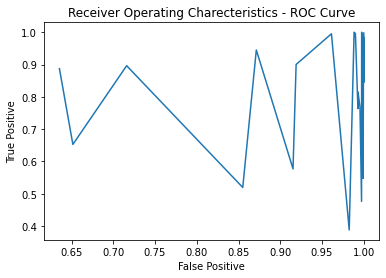

In [27]:
# ROC Curve
false_pos = np.array(sorted(ROC))[:,0]
true_pos = np.array(sorted(ROC))[:,1]
plt.plot(false_pos,true_pos)
plt.title('Receiver Operating Charecteristics - ROC Curve')
plt.xlabel('False Positive')
plt.ylabel('True Positive')
plt.show()

In [28]:
# AUC Measure
area = np.trapz(false_pos,true_pos)
print(area)

0.1563536414571639


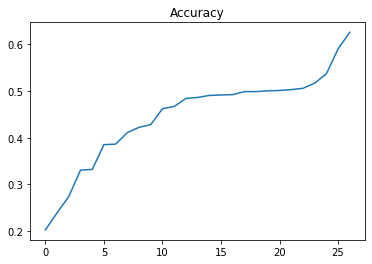

Maximum Accuracy: 62.58840224839183 %


In [29]:
# Accuracy
plt.plot(np.arange(len(ACC)),sorted(ACC))
plt.title('Accuracy')
plt.show()
print('Maximum Accuracy:',max(ACC)*100,'%')

In [134]:
# ------- For testing purpose - to get number of more accurate images -------- For our reference --------------- 
# cnt = 0
# for i in range(len(ACC)):
#     if ACC[i] > 0.60:
#         print(i,':',ACC[i])
#         cnt += 1
# print('----- total:',cnt,'------')